In [2]:
import scipy
import tensorflow
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, LSTM, Reshape
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from keras.regularizers import l2
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from PyEMD import EMD


In [3]:
# dataset_dir_control = "csv_averaged_force_data_4col/GaCo04_01.csv"
# dataset_dir_pd = "csv_averaged_force_data_4col/GaPt03_01.csv"

features = ['Time','VGRF_L1','VGRF_L2','VGRF_L3','VGRF_L4','VGRF_L5','VGRF_L6','VGRF_L7','VGRF_L8',
            'VGRF_R1','VGRF_R2','VGRF_R3','VGRF_R4','VGRF_R5','VGRF_R6','VGRF_R7','VGRF_R8','Total Force_L','Total Force_R']
file = ".../gait-in-parkinsons-disease-1.0.0/Ga_study/GaCo01_01.txt"
df = pd.read_csv(file, delim_whitespace=True, header=None)
df.columns = features


In [4]:
# Calcuating the FAV = |L_k - R_k|/L_k  x 100%
# FAV is the fluctuation amplitude variability defined as a criterion in the paper
data_directory_Ga = ".../gait-in-parkinsons-disease-1.0.0/Ga_study"
data_directory_Ju = ".../gait-in-parkinsons-disease-1.0.0/Ju_study"
data_directory_Si = ".../gait-in-parkinsons-disease-1.0.0/Si_study"
# Defining a function that goes through the entire sensor column and finding the FAV
def calculate_fav(df):
    fav_values = {}

    for i in range(1, 9):
        L = df[f'VGRF_L{i}']
        R = df[f'VGRF_R{i}']
        # Filter out instances where L is near-zero to avoid distortion in FAV calculation
        valid_indices = L > 0.01  # or another threshold appropriate for your data
        L_valid = L[valid_indices]
        R_valid = R[valid_indices]
        
        if not L_valid.empty:  # Ensure there are valid data points for calculation
            fav = (abs(L_valid - R_valid) / L_valid).mean() * 100
            fav_values[i] = fav
        else:
            fav_values[i] = 0  # or set to 0 or other indicator value

    # Sort sensors by FAV in descending order, excluding None values
    sorted_fav = sorted(fav_values.items(), key=lambda item: item[1], reverse=True)
    
    top_sensors = sorted_fav[:4]
    return top_sensors

In [5]:
top_sensors = calculate_fav(df)
print("Top 4 sensors based on FAV:", top_sensors)

Top 4 sensors based on FAV: [(1, 604.5618947398632), (7, 567.9507063523395), (6, 343.4762884711009), (4, 329.90535681168546)]


In [6]:
## Selecting the optimal sensors for each file and making a csv file 
all_fav_results = {}
data_files = [f for f in os.listdir(data_directory_Ju) if os.path.isfile(os.path.join(data_directory_Ju, f))]
features = ['Time','VGRF_L1','VGRF_L2','VGRF_L3','VGRF_L4','VGRF_L5','VGRF_L6','VGRF_L7','VGRF_L8',
            'VGRF_R1','VGRF_R2','VGRF_R3','VGRF_R4','VGRF_R5','VGRF_R6','VGRF_R7','VGRF_R8','Total Force_L','Total Force_R']

file_error = []
for file_name in data_files:
    if file_name.startswith('.'):
        # Skip hidden files like .DS_Store
        continue
    
    file_path = os.path.join(data_directory_Ju, file_name)

    try:
        df = pd.read_csv(file_path, delim_whitespace=True, header=None, encoding_errors = 'ignore')
        df.columns = ['Time'] + [f'VGRF_L{i}' for i in range(1, 9)] + [f'VGRF_R{i}' for i in range(1, 9)] + ['Total_L', 'Total_R']

        top_sensors = calculate_fav(df)
        all_fav_results[file_name] = top_sensors
    except Exception as e:
        file_error.append(file_path)


In [7]:
print(file_error)

[]


In [8]:
# Assuming `fav_values` is a dictionary with your FAV data
fav_df = pd.DataFrame(list(all_fav_results.items()), columns=['File_name', 'Optimal 4 Sensor numbers to FAV Dictionary'])
fav_df.to_csv('fav_values_Ju.csv', index=False)

In [9]:
# Selected Sensors: 2, 4, 6, 8
file = ".../gait-in-parkinsons-disease-1.0.0/Ga_study/GaCo03_02.txt"
df = pd.read_csv(file, delim_whitespace=True, header=None)
df.columns = features


def find_imfs(df):
    selected_sensors = [2, 4, 6, 8]
    emd = EMD()
    imfs_by_sensor = {}

    for sensor_num in selected_sensors:
        # For left foot sensors
        sensor_name_L = f'VGRF_L{sensor_num}'
        signal_L = df[sensor_name_L].values
        imfs_L = emd(signal_L)
        for i, imf in enumerate(imfs_L):
            imfs_by_sensor[f'{sensor_name_L}_IMF{i+1}'] = imf

        # For right foot sensors
        sensor_name_R = f'VGRF_R{sensor_num}'
        signal_R = df[sensor_name_R].values
        imfs_R = emd(signal_R)
        for i, imf in enumerate(imfs_R):
            imfs_by_sensor[f'{sensor_name_R}_IMF{i+1}'] = imf

    return imfs_by_sensor


imfs_by_sensor = find_imfs(df)
# Power spectral analysis of the IMFs using scipy.signal
def calculate_psd(imfs):
    psd_dict = {}  
    fs = 100 # sampling frequency in Hz

    for i, imf in enumerate(imfs): # imfs being 2D array & each row an IMF
        f, Pxx_den = scipy.signal.periodogram(imf, fs)
        psd_dict[f'IMF{i+1}'] = (f, Pxx_den)

    return psd_dict


In [10]:
imfs_df = pd.DataFrame(list(imfs_by_sensor.items()), columns=['sensor_name', 'IMFs'])
# imfs_df.to_csv('IMF_GaCo16_01.csv', index=False)

In [11]:
print(imfs_df['IMFs'][0].shape)

(12119,)


In [19]:
def find_imfs(df, T, file_name):
    selected_sensors = [2, 4, 6, 8]
    emd = EMD()
    imfs_by_sensor = {}
    f = 100
    start_index = 0
    end_index = len(df['VGRF_L1'])

    total_points = len(df['VGRF_L1'])

    if total_points < 12000:
        print(f"Length of {df.name} is less than 2 min: {total_points}", file=file_name)
    else:
        mid_point = total_points // 2
        start_index = mid_point - 5000 
        end_index = mid_point + 5000

        # Print the length of the original column

    for sensor_num in selected_sensors:
        sensor_name_L = f'VGRF_L{sensor_num}'
        sensor_name_R = f'VGRF_R{sensor_num}'


        # Extract the middle 100 seconds of data
        data_L = df[sensor_name_L].values[start_index:end_index]
        data_R = df[sensor_name_R].values[start_index:end_index]

        # Apply EMD and round the IMFs to two decimal places
        imfs_L = np.round(emd(data_L), 2)
        imfs_R = np.round(emd(data_R), 2)

        if imfs_L.shape[0] > T:
            imfs_L = imfs_L[:T]
            imfs_R = imfs_R[:T]

        # Print the length of the generated array

        imfs_by_sensor[sensor_name_L] = imfs_L
        imfs_by_sensor[sensor_name_R] = imfs_R
    
    print(f"Length of IMF for {df.name} is: {imfs_L.size}", file=file_name)

    return imfs_by_sensor


def find_imfs_no_log(df, T):
    selected_sensors = [2, 4, 6, 8]
    emd = EMD()
    imfs_by_sensor = {}
    f = 100
    start_index = 0
    end_index = len(df['VGRF_L1'])

    total_points = len(df['VGRF_L1'])

    for sensor_num in selected_sensors:
        sensor_name_L = f'VGRF_L{sensor_num}'
        sensor_name_R = f'VGRF_R{sensor_num}'

        # Extract the middle 100 seconds of data
        data_L = df[sensor_name_L].values[start_index:end_index]
        data_R = df[sensor_name_R].values[start_index:end_index]

        # Apply EMD and round the IMFs to two decimal places
        imfs_L = np.round(emd(data_L), 2)
        imfs_R = np.round(emd(data_R), 2)

        if imfs_L.shape[1] > T:
            imfs_L = imfs_L[:, :T]
            imfs_R = imfs_R[:, :T]


        # Print the length of the generated array

        imfs_by_sensor[sensor_name_L] = imfs_L
        imfs_by_sensor[sensor_name_R] = imfs_R
    
    # print(f"Length of IMF for {df.name} is: {imfs_L.size}", file=file_name)

    return imfs_by_sensor



def calculate_psd(imfs):
    psd_dict = {}
    fs = 100  # Sampling frequency in Hz

    for i, imf in enumerate(imfs):
        f, Pxx_den = scipy.signal.periodogram(imf, fs)
        psd_dict[f'IMF{i + 1}'] = (f, Pxx_den)

    return psd_dict

def process_individual_file(df, T, num_dominant_IMFs, num_sensors, log_file):
    selected_sensors = [2, 4, 6, 8]
    imfs_individual = find_imfs(df, T, log_file)
    imfs_individual_selected = {}

    for sensor_index in selected_sensors:
        sensor_name_L = f'VGRF_L{sensor_index}'
        sensor_name_R = f'VGRF_R{sensor_index}'

        imfs_L = imfs_individual[sensor_name_L]
        imfs_R = imfs_individual[sensor_name_R]

        psd_L = calculate_psd(imfs_L)
        psd_R = calculate_psd(imfs_R)
        dominant_imfs_L_dict = find_dominant_imfs(psd_L, num_dominant_IMFs)
        dominant_imfs_R_dict = find_dominant_imfs(psd_R, num_dominant_IMFs)

        for i, (key, _) in enumerate(dominant_imfs_L_dict.items()):
            imfs_individual_selected[f'{sensor_name_L}_IMF{i + 1}'] = np.round(imfs_L[int(key.replace('IMF', '')) - 1], 2)
        for i, (key, _) in enumerate(dominant_imfs_R_dict.items()):
            imfs_individual_selected[f'{sensor_name_R}_IMF{i + 1}'] = np.round(imfs_R[int(key.replace('IMF', '')) - 1], 2)

    return imfs_individual_selected

def process_individual_file_no_log(df, T, num_dominant_IMFs, num_sensors):
    selected_sensors = [2, 4, 6, 8]
    imfs_individual = find_imfs_no_log(df, T)
    imfs_individual_selected = {}

    for sensor_index in selected_sensors:
        sensor_name_L = f'VGRF_L{sensor_index}'
        sensor_name_R = f'VGRF_R{sensor_index}'

        imfs_L = imfs_individual[sensor_name_L]
        imfs_R = imfs_individual[sensor_name_R]

        psd_L = calculate_psd(imfs_L)
        psd_R = calculate_psd(imfs_R)
        dominant_imfs_L_dict = find_dominant_imfs(psd_L, num_dominant_IMFs)
        dominant_imfs_R_dict = find_dominant_imfs(psd_R, num_dominant_IMFs)

        for i, (key, _) in enumerate(dominant_imfs_L_dict.items()):
            imfs_individual_selected[f'{sensor_name_L}_IMF{i + 1}'] = np.round(imfs_L[int(key.replace('IMF', '')) - 1], 2)
        for i, (key, _) in enumerate(dominant_imfs_R_dict.items()):
            imfs_individual_selected[f'{sensor_name_R}_IMF{i + 1}'] = np.round(imfs_R[int(key.replace('IMF', '')) - 1], 2)

    return imfs_individual_selected

# dataset_dir_control = "csv_averaged_force_data_4col/GaCo04_01.csv"
# dataset_dir_pd = "csv_averaged_force_data_4col/GaPt03_01.csv"

In [322]:
## for consolidating data into a matrix of individual data in the Ju study

data_files = [f for f in os.listdir(data_directory_Ju) if os.path.isfile(os.path.join(data_directory_Ju, f)) and f.endswith('01.txt')]
features = ['Time', 'VGRF_L1', 'VGRF_L2', 'VGRF_L3', 'VGRF_L4', 'VGRF_L5', 'VGRF_L6', 'VGRF_L7', 'VGRF_L8',
            'VGRF_R1', 'VGRF_R2', 'VGRF_R3', 'VGRF_R4', 'VGRF_R5', 'VGRF_R6', 'VGRF_R7', 'VGRF_R8', 'Total Force_L', 'Total Force_R']

# all_data_df = pd.DataFrame()  # Initialize an empty DataFrame to store all data
all_data_df = pd.DataFrame()
file_error = []
all_individuals_labels = []
all_individuals_matrices = []


for file_name in data_files:
    if file_name.startswith('.'):
            # Skip hidden files like .DS_Store
            continue

    print(f"Processing file: {file_name}")
        
    file_path = os.path.join(data_directory_Ju, file_name)
    

    try:
        df = pd.read_csv(file_path, delim_whitespace=True, header=None, encoding_errors='ignore')
        df.columns = features
        df.name = file_name.split('\\')[-1]

        T = 6000 # 1 min of data expected minimum.
        num_dominant_IMFs = 3  # Adjust as needed
        num_sensors = 4  # Adjust as needed
        dominant_imfs = process_individual_file_no_log(df, T, num_dominant_IMFs, num_sensors)
        
        imfs_df = pd.DataFrame(list(dominant_imfs.items()), columns=['sensor_name', 'IMFs'])
        
        imfs_matrix = np.vstack([dominant_imfs[key] for key in sorted(dominant_imfs.keys())]).T
        print(imfs_matrix)  
        if imfs_matrix.shape == (6000,24):
            all_individuals_matrices.append(imfs_matrix)


        # imfs_with_matrix = pd.DataFrame(imfs_matrix, columns = ['Individual IMFs Matrix'])

        # Assuming it returns a DataFrame or Series that you want to append
        # processed_data = process_individual_file(df, T, num_dominant_IMFs, num_sensors)
            if 'Pt' in file_name:
                # imfs_with_matrix['Health'] = 1
                all_individuals_labels.append(1)
            elif 'Co' in file_name:
                # imfs_with_matrix['Health'] = 0
                all_individuals_labels.append(0)

        # imfs_with_matrix = pd.DataFrame(imfs_matrix, columns = ['Individual IMFs Matrix','Health'])

        # Assuming processed_data is a DataFrame or Series that can be appended directly
        # all_data_df = pd.concat([all_data_df, imfs_with_matrix], ignore_index=True)

        
    except Exception as e:
        print(f"Error processing file {file_name}: {e}")
        file_error.append(file_path)


# Now `all_data_df` contains all the processed data from each file
print("All data has been processed and combined into a single DataFrame.")

# Optionally, if you want to save the final DataFrame:
# all_data_df.to_csv('path/to/save/final_combined_data.csv', index=False)

if file_error:
    print("Files with errors:", file_error)
else:
    print("All files processed successfully.")

# print(imfs_df)

Processing file: JuCo23_01.txt
[[ 8.6000e-01  8.6680e+01  4.3809e+02 ...  2.0000e-02  5.4200e+01
  -8.8600e+01]
 [ 1.7700e+00  8.6920e+01  4.3424e+02 ...  9.0000e-02  5.5680e+01
  -8.8640e+01]
 [ 2.4900e+00  8.6270e+01  4.3031e+02 ...  1.4000e-01  5.6980e+01
  -8.8640e+01]
 ...
 [-1.1421e+02  7.5650e+01 -1.5080e+01 ... -7.9080e+01 -4.4000e+00
  -1.2400e+00]
 [-1.0560e+02  6.9020e+01 -1.7800e+01 ... -7.9220e+01 -3.9100e+00
   1.1000e-01]
 [-9.6750e+01  6.2070e+01 -2.0520e+01 ... -7.8940e+01 -3.3900e+00
   1.4400e+00]]
Processing file: JuPt12_01.txt
[[ 47.97  -0.56  27.11 ...  -5.49  -3.15   1.83]
 [ 51.2   -0.93  27.46 ...  -5.59  -3.45   1.86]
 [ 54.4   -1.04  27.8  ...  -5.48  -3.95   1.44]
 ...
 [ 55.38  37.46  59.57 ...   0.65  -7.44 -14.43]
 [ 58.16  34.32  61.51 ...   0.91 -13.49 -19.82]
 [ 60.56  30.54  63.34 ...   1.17 -19.4  -24.26]]
Processing file: JuCo07_01.txt
[[-2.900e+00 -1.256e+01  1.189e+01 ... -2.672e+01  8.440e+00 -6.000e-02]
 [-4.070e+00 -1.298e+01  1.287e+01 ... -2.

In [334]:
## Splitting the data

X_train, X_test, y_train, y_test = train_test_split(all_individuals_matrices_np, all_individuals_labels_np, test_size=0.15, random_state=42)

In [336]:
# model.fit(X_train,y_train, validation_batch_size=(X_test, y_test), epochs =100)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print(X_train.shape)
print(X_train.dtype)
print(y_test.shape)


(39, 6000, 24)
float32
(7,)


In [500]:
## NOW ONTO ML TRAINING 

# Define model architecture - based on StackOverFlow
# Link: https://stackoverflow.com/questions/55433649/how-to-combine-lstm-and-cnn-models-in-keras


num_time_steps = 6000
num_features = 24

# For explanation of the architecture to its parameters, detailed comments are added

model = Sequential() # linear stack of layers in Keras (the API used by TensorFlow )

## CNN Layers:

# Firstly comes the 1D convolutional layer
# Filters = 64 as number of outputs filters in the convolution, kernel size=3 of 1D convolution window
# Activation function used per the paper is rectified linear unit
model.add(Conv1D(filters=64, kernel_size = 3, activation = 'relu',input_shape= (num_time_steps, num_features), kernel_regularizer=l2(0.01))) # if needed: 

# This layer is for downsampling the input along the time dimensions (time series)
# To detect invariant features with a pooling window size of 2
model.add(MaxPooling1D(pool_size=2))

# Regularization common to prevent overfitting
model.add(Dropout(0.5))

# Another 1D convolution layer, also commonly used to stack convolutional and pooling layers
# to allow the model to learn more complex features
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

## Prepare for LSTM layer by retaining the time dimension based on output shape of MaxPooling:
model.add(Flatten())
model.add(Reshape((-1, 128)))

# LSTM Layer
model.add(LSTM(100, dropout=0.5, return_sequences=False, kernel_regularizer=l2(0.01)))  

# Now add Dense layers
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_183 (Conv1D)             │ (None, 5998, 64)       │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_179               │ (None, 2999, 64)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_229 (Dropout)           │ (None, 2999, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_184 (Conv1D)             │ (None, 2997, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_180               │ (None, 1498, 64)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_230 (Dropout)           │ (None, 1498, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_74 (Flatten)            │ (None, 95872)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_71 (Reshape)            │ (None, 749, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 100)            │        91,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_231 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,825 (464.16 KB)

 Trainable params: 118,825 (464.16 KB)

 Non-trainable params: 0 (0.00 B)

In [505]:
model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), batch_size=5, epochs=3)

Epoch 1/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.6846 - loss: 1.9197 - val_accuracy: 0.7143 - val_loss: 1.8605
Epoch 2/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - accuracy: 0.2963 - loss: 2.0004 - val_accuracy: 0.7143 - val_loss: 1.8009
Epoch 3/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.5260 - loss: 1.8904 - val_accuracy: 0.8571 - val_loss: 1.7519


In [506]:
test_loss, test_accuarcy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuarcy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8571 - loss: 1.7944
Test Loss: 1.7944228649139404
Test Accuracy: 0.8571428656578064


In [507]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


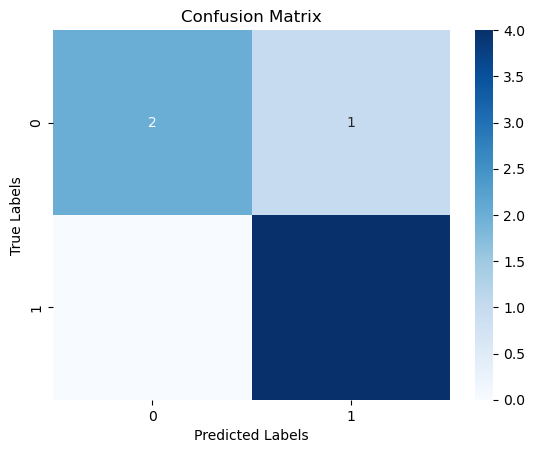

In [508]:
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title("Confusion Matrix")
plt.show()